In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [23]:
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)        

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=uint8), array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,  38, 168, 254, 157,   0,   0,   0,
         0,   0], dtype=uint8), array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  98, 223, 253, 253, 145,   0,   0,   0,
         0,   0], dtype=uint8), array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,  41, 222, 253, 253, 183,  14,   0,   0,   0,
         0,   0], dtype=uint8), array([  0,   0,   

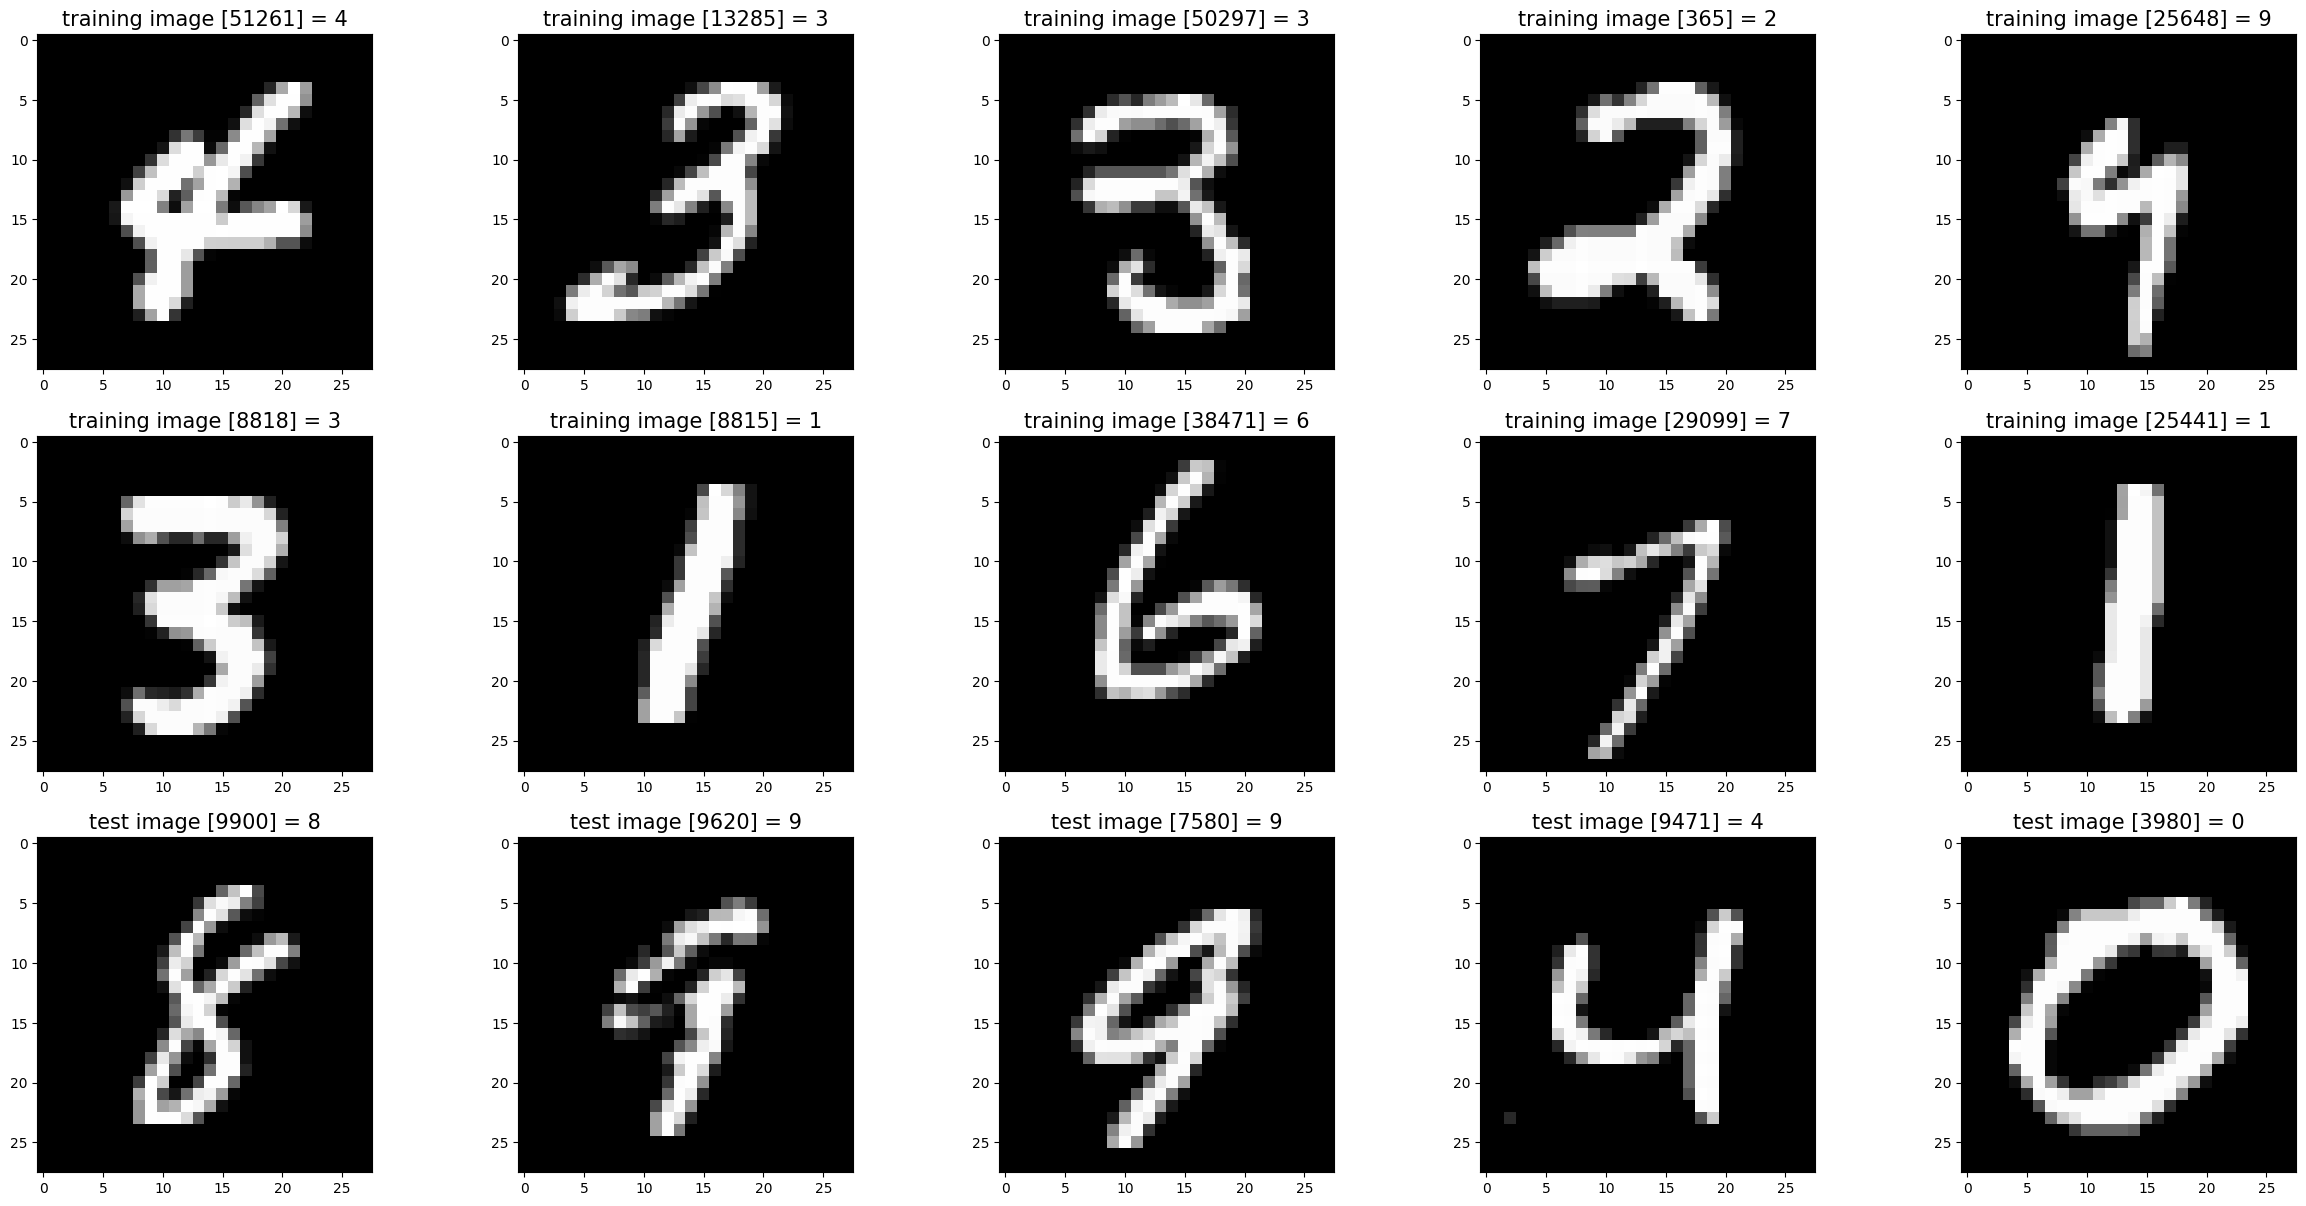

In [24]:
%matplotlib inline
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = '.'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

#
# Helper function to show a list of images with their relating titles
#
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);        
        index += 1

#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

#
# Show some random training and test images 
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))    

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])        
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))    

show_images(images_2_show, titles_2_show)
print(images_2_show[0])

In [25]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [26]:
cnn = CNN()

In [27]:
cnn(torch.tensor(x_train[0]).unsqueeze(0).float())

tensor([[ -6.0746, -21.6543,  -7.4644,  12.1333,  22.1866,   2.5331,  -5.4792,
          -5.9197,  -2.0621,   7.8378]], grad_fn=<AddmmBackward0>)

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [29]:
cnn.to(device)

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [30]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.001)

In [31]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convert to tensor
    transforms.RandomRotation(10),  # Rotate the image randomly by up to 10 degrees
    transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random translation up to 10% of the image size
    transforms.RandomAffine(0, scale=(0.9, 1.1)),  # Random scaling between 90% and 110%
    transforms.RandomAffine(0, shear=10),  # Random shearing up to 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly adjust brightness and contrast
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),  # Add Gaussian blur
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize using MNIST mean and std
])


test_transforms = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081))])

In [32]:
from torch.utils.data import DataLoader, Dataset
class Dataset(Dataset):
    def __init__(self, X, y, transformer): 
        self.X = X 
        self.y = y 
        self.transformer = transformer 

    def __len__(self):
        return len(self.X) 

    def __getitem__(self, idx):
        X = self.transformer(np.array(self.X[idx]))
        return X, self.y[idx]

In [33]:
train_dataset = Dataset(x_train, y_train, train_transforms)
test_dataset = Dataset(x_test, y_test, test_transforms)
print(train_dataset[0][0])
cnn(train_dataset[0][0].to(device))

tensor([[[-4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,
          -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,
          -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,
          -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,
          -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,
          -4.2421e-01, -4.2421e-01, -4.2421e-01],
         [-4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,
          -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,
          -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,
          -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,
          -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,
          -4.2421e-01, -4.2421e-01, -4.2421e-01],
         [-4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,
          -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01, -4.2421e-01,


tensor([[ 0.0274, -0.0872,  0.1207, -0.0512,  0.1538, -0.1414, -0.1589,  0.0048,
         -0.0591,  0.0955]], grad_fn=<AddmmBackward0>)

In [34]:
print(len(test_dataset))

10000


In [35]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [36]:
import matplotlib.pyplot as plt 
def train_and_validate(cnn, train_loader, val_loader, num_epochs, device, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(cnn.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        cnn.train()
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = cnn(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if batch_idx % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        # Calculate average training loss for this epoch
        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation
        cnn.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, targets in val_loader:
                data, targets = data.to(device), targets.to(device)
                outputs = cnn(data)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    
    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

Epoch [1/10], Step [1/938], Loss: 2.2993
Epoch [1/10], Step [101/938], Loss: 0.6736
Epoch [1/10], Step [201/938], Loss: 0.4329
Epoch [1/10], Step [301/938], Loss: 0.5461
Epoch [1/10], Step [401/938], Loss: 0.3419
Epoch [1/10], Step [501/938], Loss: 0.1668
Epoch [1/10], Step [601/938], Loss: 0.1431
Epoch [1/10], Step [701/938], Loss: 0.2135
Epoch [1/10], Step [801/938], Loss: 0.1126
Epoch [1/10], Step [901/938], Loss: 0.2206
Epoch [1/10], Training Loss: 0.3694, Validation Loss: 0.0515
Epoch [2/10], Step [1/938], Loss: 0.1540
Epoch [2/10], Step [101/938], Loss: 0.1966
Epoch [2/10], Step [201/938], Loss: 0.1392
Epoch [2/10], Step [301/938], Loss: 0.3391
Epoch [2/10], Step [401/938], Loss: 0.2440
Epoch [2/10], Step [501/938], Loss: 0.1491
Epoch [2/10], Step [601/938], Loss: 0.1188
Epoch [2/10], Step [701/938], Loss: 0.0539
Epoch [2/10], Step [801/938], Loss: 0.2121
Epoch [2/10], Step [901/938], Loss: 0.3159
Epoch [2/10], Training Loss: 0.1640, Validation Loss: 0.0319
Epoch [3/10], Step [1/

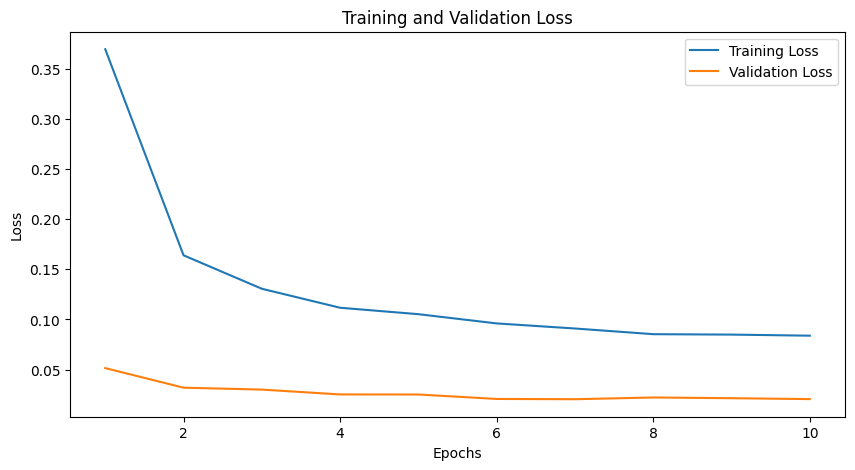

In [37]:

num_epochs = 10
train_and_validate(cnn, train_loader, test_loader, num_epochs, device, learning_rate=0.001)

In [38]:
device = 'cpu'
print(len(test_loader))
cnn.eval()
cnn.to(device)
correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(device), targets.to(device)
        outputs = cnn(data)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy on the test set: {100 * correct / total:.2f}%')

157
Accuracy on the test set: 99.31%


In [39]:

cnn(train_dataset[2][0].to(device))

tensor([[-16.3178,  -4.3952,  -6.5990, -14.5187,  16.3563,  -6.7897,  -7.1807,
          -5.6522,  -1.5972,  -0.2755]], grad_fn=<AddmmBackward0>)

In [26]:
for name, param in cnn.named_parameters():
    print(name)
    print(param.data.shape)
    if name == 'conv1.weight':
        print(param.data)


conv1.weight
torch.Size([32, 1, 3, 3])
tensor([[[[ 0.3074, -0.2949, -0.0371],
          [ 0.1789, -0.1049, -0.2289],
          [-0.0251,  0.0183, -0.0226]]],


        [[[-0.2689,  0.3488, -0.3063],
          [ 0.0926,  0.0484,  0.1724],
          [ 0.1639, -0.2584, -0.0441]]],


        [[[-0.0463,  0.3366,  0.0442],
          [ 0.3206,  0.1322, -0.3735],
          [ 0.0319, -0.1841, -0.4014]]],


        [[[-0.1757, -0.3566, -0.1428],
          [-0.3324,  0.1826,  0.3675],
          [ 0.4008,  0.3152, -0.2558]]],


        [[[-0.4378,  0.1370, -0.0704],
          [-0.2477,  0.1868,  0.2817],
          [-0.0411,  0.2657, -0.0055]]],


        [[[-0.3162, -0.2788,  0.1847],
          [-0.1372, -0.2414,  0.2609],
          [-0.3221,  0.1679,  0.3138]]],


        [[[ 0.0154, -0.2133, -0.0922],
          [-0.0967, -0.1785, -0.0420],
          [-0.2274,  0.2161, -0.1408]]],


        [[[ 0.0141, -0.4137, -0.4418],
          [ 0.1820,  0.0238,  0.0980],
          [ 0.0911,  0.1621,  0.3310

In [40]:
import struct 


In [41]:
def save_weights_to_binary(model, filename): 
    with open(filename, 'wb') as f:
        for name, param in model.named_parameters():
            weights = param.data.cpu().numpy()
            f.write(struct.pack("I", len(name))) 
            f.write(name.encode('utf-8'))
            f.write(struct.pack('I', len(weights.shape)))
            for dim in weights.shape: 
                f.write(struct.pack('I', dim))
            f.write(weights.tobytes())

save_weights_to_binary(cnn, 'cnn_weights_v2.bin')